In [1]:
#header file
import torch
from torch import nn
from torch.nn import functional as F 
from torch.utils.data import DataLoader
import torchvision 
from visdom import Visdom
import hiddenlayer as hl

In [2]:
class Flatten(nn.Module):
    
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
class ResBlk(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(ResBlk, self).__init__()
        
        self.conv1 = nn.Conv2d(in_ch, in_ch, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.conv2 = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_ch)
        self.conv3 = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_ch)

        self.extra = nn.Sequential()
        if out_ch != in_ch:
            self.extra = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_ch)
            )

#         tmp = torch.randn(2, 16, 32, 32)
#         out = F.relu(self.bn1(self.conv1(tmp)))
#         print("after conv1 unit: ", out.shape)
#         out = F.relu(self.bn2(self.conv2(out)))
#         print("after conv2 unit: ", out.shape)
#         out = self.bn3(self.conv3(out))
#         print("after conv3 unit: ", out.shape)
#         out = self.extra(tmp) + out
#         print("out layer: ", out.shape)
        
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.extra(x) + out

        return out

In [4]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16)
        )
        
        #just use 2 residual model 
        self.blk1 = ResBlk(16, 16)
        self.blk2 = ResBlk(16, 32)

        self.outlayer = nn.Linear(32*32*32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.blk1(x)
        x = self.blk2(x)
        x = x.view(x.size(0), -1)
        x = self.outlayer(x)

        return x

In [5]:
#initialize varience
batchsz = 32
learning_rate = 1e-3
epochs = 10

In [6]:
#load dataset
train_loader = DataLoader(
    torchvision.datasets.MNIST("mnist", train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize([32, 32]),
        torchvision.transforms.ToTensor()
    ])),
    batch_size=batchsz, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("mnist", train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize([32, 32]),
        torchvision.transforms.ToTensor()
    ])),
    batch_size=batchsz, shuffle=True
)

#observe dataset sample
data, label = next(iter(train_loader))
print("data shape: ", data.shape, " label shape: ", label.shape)

data shape:  torch.Size([32, 1, 32, 32])  label shape:  torch.Size([32])


In [7]:
#use gpu
device = torch.device("cuda:0")

In [8]:
torch.cuda.empty_cache()

In [9]:
#import model
model = ResNet18().to(device)
#observe model structure
print(model)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blk1): ResBlk(
    (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (extra): Sequential()
  )
  (blk2): ResBlk(
    (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(

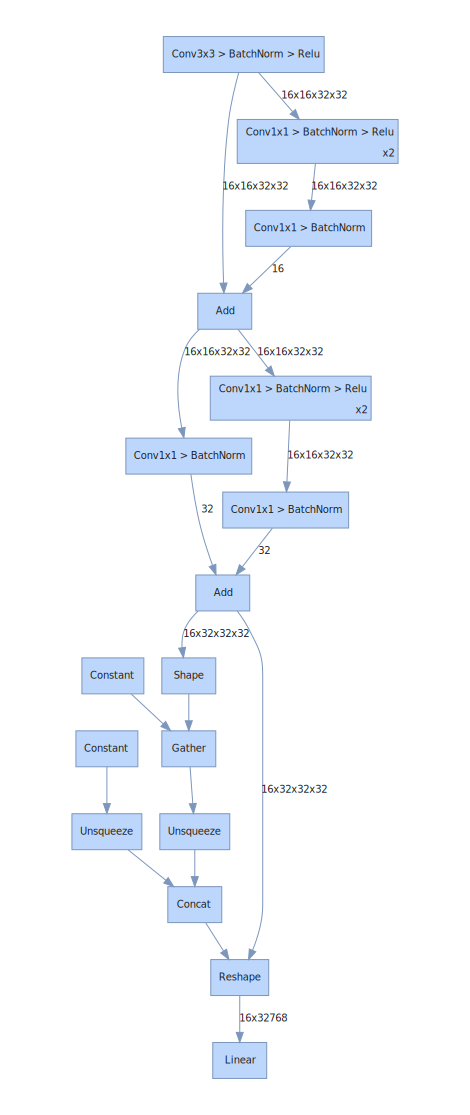

In [10]:
# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([16, 1, 32, 32]).to(device))
# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

In [11]:
#initialize optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#initialize cross entropy loss function
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
#initalize visdom
viz = Visdom()  
#train loss
viz.line([0.], [0.], win='train_loss', opts=dict(title="train loss"))
#test loss 
viz.line([0.], [0.], win="test_loss", opts=dict(title='test loss'))
#test acc
viz.line([0.], [0.], win='test_acc', opts=dict(title="test accuary"))

'test_acc'

In [ ]:
global_step = 0

#iterative training 
for epoch in range(epochs):

    #trian model 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        #forward propagation 
        logits = model(data)
        loss = criterion(logits, target)

        #backward propagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #visdom 
        global_step += 1
        viz.line([loss.item()], [global_step], win='train_loss', update='append')


    #test model 
    model.eval()
    with torch.no_grad():
        total_correct = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            #forward propagation 
            logits = model(data)
            pred = logits.argmax(dim=1)
            loss = criterion(logits, target).item()
            test_loss += loss

            #calcuate the correct num
            correct = torch.eq(pred, target).float().sum().item()
            total_correct += correct

        acc = total_correct / len(test_loader.dataset)

        #visdom 
        viz.line([test_loss], [global_step], win="test_loss", update='append')
        viz.line([acc], [global_step], win="test_acc", update='append')
        
        print(epoch, "acc: ", acc)

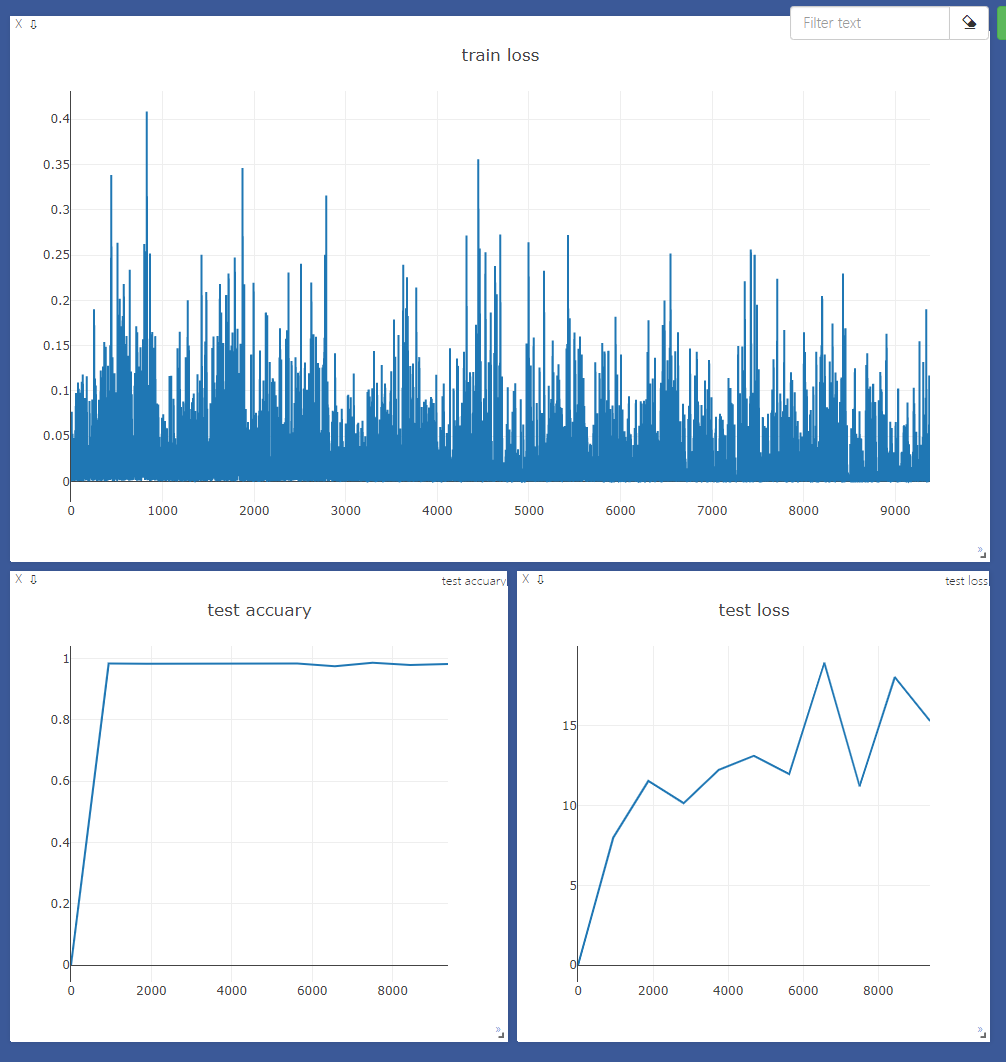